# Galaxy Classification using Supervised Learning with Deep Convolutional Neural Networks for Multi-Class Image Classification
## Group 7 AI Class Final Projects
Members:
- Abi
- Gavin
- Rasyid
- Hikmal

---

### Import Libraries

In [1]:
#Change/add any additional imports here
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Optional, forces CPU only
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

### Data Wrangling & Preprocessing

In [2]:
#Process the labels first
def major_class(t):
    t = str(t).strip()
    if t.startswith("E"):
        return "E"
    elif t.startswith("S0"):
        return "E" #S0 is closer to E (Lenticular)
    elif t.startswith("SABa"):
        return "S" #SAB is closer to SB (Barred Spiral)
    elif t.startswith("SABb"):
        return "S" #SAB is closer to SB (Barred Spiral)
    elif t.startswith("SABc"):
        return "SB" #SAB is closer to SB (Barred Spiral)
    elif t.startswith("SABd"):
        return "SB" #SAB is closer to SB (Barred Spiral)
    elif t.startswith("SB"):
        return "SB"
    elif t.startswith("S"):
        return "S"
    else:
        return "Other"  #Catchall for irregular/unknown types

df = pd.read_csv('efigiuse/label.csv')
print(df.head())
print("\nunique classes:")
print(df["type"].unique()) #Checking the unique classes
df["major_class"] = df["type"].apply(major_class)
print(df["major_class"].value_counts()) #Checking the number of major classes

#Create new dataframe with only PGC_name and major_class columns
df_major = df[["PGC_name", "major_class"]]
print(df_major.head(15)) #df_major at a glance

#Create a filtered version of df_major ("Other" class removed)
df_use = df_major[df_major["major_class"] != "Other"].reset_index(drop=True)
print(df_use.head(15)) #df_use at a glance

#Label processing complete

     PGC_name  PGC_no     vrad  e_vrad     vopt  e_vopt        v   e_v  \
0  PGC0000212   212.0  11230.4     4.5  11110.0    47.0  11229.3   9.0   
1  PGC0000218   218.0   1050.3     4.8   1027.4    25.0   1049.5   4.5   
2  PGC0000243   243.0  -9999.0 -9999.0   8914.3    16.3   8914.3  16.3   
3  PGC0000255   255.0    878.1     4.1  -9999.0 -9999.0    878.1   4.1   
4  PGC0000281   281.0  -9999.0 -9999.0  11490.7    16.4  11490.7  16.4   

      vvir      zvir     z_err type    objname            hl_names  
0  11287.9  0.037650  0.000030  Sab     IC5381           PGC000212  
1   1109.0  0.003699  0.000015  Sab    NGC7814          PGC1501809  
2   8841.8  0.029490  0.000054   S0    NGC7808  6dFJ0003321-104441  
3    932.9  0.003112  0.000014   Sm   UGC00017           PGC000255  
4  11416.0  0.038080  0.000055   Sc  PGC000281       MCG-02-01-015  

unique classes:
['Sab' 'S0' 'Sm' 'Sc' 'Sa' 'Sd' 'SBa' 'IB' 'Sb' 'SABc' 'SBc' 'SBb' 'Scd'
 'S0-a' 'I' 'SBbc' 'SBd' 'E' 'SBm' 'SABa' 'SABb' '|

In [3]:
#Image processing
image_dir = "efigiuse/png/"
image_size = (255, 255)
X, y = [], [] #Initialize empty lists for images and labels
for idx, row in df_use.iterrows():
    image_path = os.path.join(image_dir, f"{row['PGC_name']}.png")
    if os.path.exists(image_path):
        img = load_img(image_path, target_size=image_size)
        img_array = img_to_array(img) / 255.0  #Normalization to [0, 1]
        X.append(img_array) #X is for the images
        y.append(row["major_class"]) #y is for the labels
    else:
        print(f"Missing image: {image_path}")
#No images should be missing. If any are, check efigiuse/png/ and redownload the images from: 
#https://www.astromatic.net/download/efigi/efigi_png_gri-1.6.tgz
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y) #Label encoding
print("Classes: " + str(encoder.classes_)) #Checking the classes, should be ["E", "S", "SB"]

#Train, validation, and test split
X = np.array(X) #Convert X & y to numpy arrays
y_encoded = np.array(y_encoded)
#Train (70%) - Rest (30%) split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.30, random_state=42, stratify=y_encoded)
#Validation (15%) - Test (15%) split
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

#Training data augmentation to prevent overfitting
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

Classes: ['E' 'S' 'SB']


### CNN Architecture Building

In [4]:
from sklearn.utils.class_weight import compute_class_weight

num_classes = len(df_use["major_class"].unique()); print("Number of classes: " + str(num_classes)) #Checking the number of classes
#Current arrays are integer coded (0,1,2). Convert to one-hot encoding
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

weight_decay = 1e-4 #L2 regularization parameter
#Class weights to handle class imbalance (especially for SB class (2))
# class_weights = {0: 1.2486979166666667, 1: 0.7365591397849462, 2: 1.1883519206939281}
y_train_int = np.argmax(y_train, axis=1)

# Compute class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)
# Convert to dictionary format expected by model.fit
class_weights = dict(enumerate(class_weights_array))
#Source:
# class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_int), y=y_train_int)
# class_weights = dict(enumerate(class_weights_array))
# print("Class weights: ", class_weights)

model = Sequential([
    Input(shape=(255, 255, 3)),
    Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(weight_decay)),
    Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(weight_decay)),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(weight_decay)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(weight_decay)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    Dropout(0.5),  #Prevents overfitting
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=30,
                    callbacks=[early_stop],
                    class_weight=class_weights)

#WARNING: MAKE SURE TO HAVE A GENUINELY GOOD COMPUTING SETUP WITH MAXIMUM COOLING AND POWER BEFORE EXECUTING
#DO NOT LET YOUR MACHINE GET OVERHEATED


Number of classes: 3
Epoch 1/30
90/90 [==============================] - 98s 1s/step - loss: 1.2616 - accuracy: 0.4745 - val_loss: 3.0239 - val_accuracy: 0.2305
Epoch 2/30
90/90 [==============================] - 105s 1s/step - loss: 1.0816 - accuracy: 0.5214 - val_loss: 1.5287 - val_accuracy: 0.3052
Epoch 3/30
90/90 [==============================] - 101s 1s/step - loss: 0.9595 - accuracy: 0.5558 - val_loss: 0.9393 - val_accuracy: 0.4302
Epoch 4/30
90/90 [==============================] - 107s 1s/step - loss: 0.8983 - accuracy: 0.5523 - val_loss: 0.8729 - val_accuracy: 0.5471
Epoch 5/30
90/90 [==============================] - 106s 1s/step - loss: 0.8458 - accuracy: 0.5714 - val_loss: 0.8701 - val_accuracy: 0.5211
Epoch 6/30
90/90 [==============================] - 109s 1s/step - loss: 0.8377 - accuracy: 0.5753 - val_loss: 0.8952 - val_accuracy: 0.5308
Epoch 7/30
90/90 [==============================] - 109s 1s/step - loss: 0.8310 - accuracy: 0.5850 - val_loss: 0.9222 - val_accuracy: 

In [5]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes))
print(confusion_matrix(y_true, y_pred_classes))

20/20 [==============================] - 4s 211ms/step - loss: 0.8043 - accuracy: 0.6483
Test Accuracy: 0.6483
20/20 [==============================] - 5s 215ms/step
              precision    recall  f1-score   support

           0       0.68      0.90      0.77       165
           1       0.69      0.65      0.67       310
           2       0.47      0.36      0.41       142

    accuracy                           0.65       617
   macro avg       0.61      0.64      0.62       617
weighted avg       0.64      0.65      0.64       617

[[149  15   1]
 [ 54 200  56]
 [ 17  74  51]]


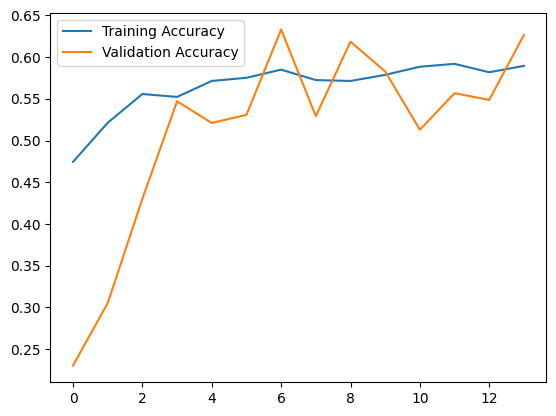

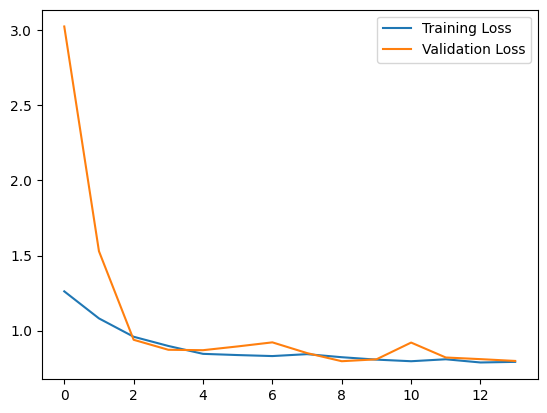

In [6]:
#Training history plots to visualize performance (underfitting/overfitting)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()